In [1]:
# Import required libraries
import os
import geopandas as gpd
import rasterio
from shapely.geometry import box
import matplotlib.pyplot as plt
import pdemtools as ptd
import pandas as pd
import numpy as np


#### Individual ArcticDEM strip

In [ ]:
## REQUIRED INPUTS ##

# Define the filepath to a folder containing co-registered and geoid-corrected DEMs
ArcticDEM_strips = 'R:/KOGE_BUGT/QGIS/ArcticDEM/Koge_Bugt_Central/kogebugtcentral_data_geoid_corrected/'

# Specify the desired date to be plotted
desired_date = '20160917'  # 'YYYYMMDD'

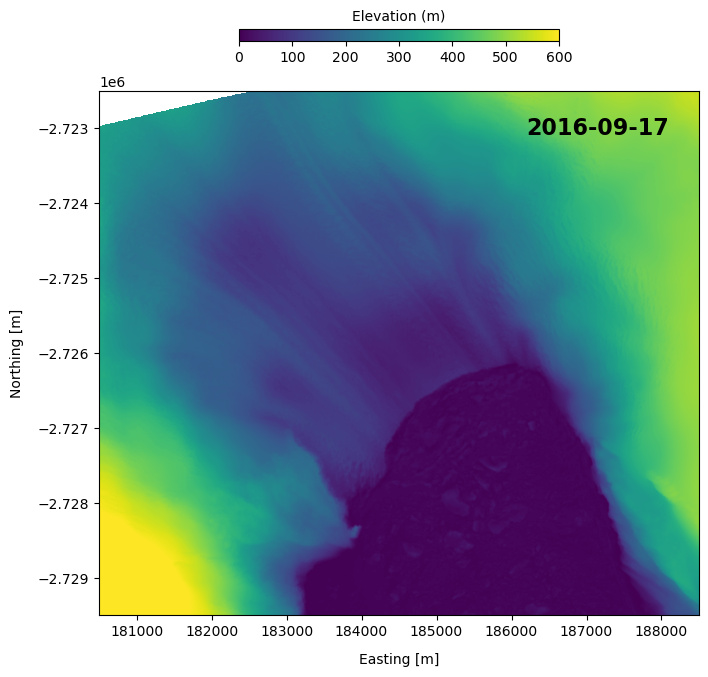

In [85]:
# If a DEM is available on the specified date, plot the DEM
data = []
for filename in os.listdir(ArcticDEM_strips):
    if filename.endswith('_coreg.tif'):
        date_str = filename[:8] # Extract the date from the filename
        file_date = pd.to_datetime(date_str) # Convert the date to a datetime object
        file_path = os.path.join(ArcticDEM_strips, filename)
        with rasterio.open(file_path) as src:
            bounds = src.bounds
            geometry = box(*bounds)
            crs = src.crs # Extract the coordinate system of the DEM
        data.append({'filename': filename,'file_path': file_path,'geometry': geometry,'pdt_datetime1': file_date})
        
gdf = gpd.GeoDataFrame(data, crs=crs)
filtered_gdf = gdf[gdf['pdt_datetime1'] == pd.to_datetime(desired_date)] # Filter the GeoDataFrame to only include the file on the specified date

if not filtered_gdf.empty:
    selected_file = filtered_gdf.iloc[0]
    with rasterio.open(selected_file['file_path']) as src:
        img = src.read(1)  
        fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
        zoom_coords = (180500, 188500, -2729500, -2722500) # Set the zoomed bounds of the plot to be shown
        ax.set_xlim(zoom_coords[0], zoom_coords[1])
        ax.set_ylim(zoom_coords[2], zoom_coords[3])
        min_height = 0 # Set the minimum height value
        max_height = 600 # Set the maximum height value
        cax = ax.imshow(img, cmap='viridis', extent=(bounds.left, bounds.right, bounds.bottom, bounds.top), vmin=min_height, vmax=max_height)
        ax.set_xlabel('Easting [m]', labelpad=10) # Add labels to the x and y axes
        ax.set_ylabel('Northing [m]', labelpad=10)
        gpd.GeoDataFrame([selected_file]).plot(ax=ax, fc='none')
        ax.text(0.95, 0.95, selected_file.pdt_datetime1.date(), transform=ax.transAxes,
                fontsize=16, verticalalignment='top', horizontalalignment='right', fontweight='bold') # Add the date of the DEM to the plot
        cbar_ax = fig.add_axes([0.3, 1.05, 0.4, 0.02])
        cbar = fig.colorbar(cax, cax=cbar_ax, orientation='horizontal') # Add a colorbar to the plot
        cbar.set_label('Elevation (m)', labelpad=6)
        cbar_ax.xaxis.set_label_position('top')
        plt.show()
else:
    print(f"No files found for date {desired_date}") # Print a message if no files are found for the specified date

#### Plot and save multiple ArcticDEM strips

In [2]:
## REQUIRED INPUTS ##

# Define the filepath to a folder containing co-registered and geoid-corrected DEMs.
input_folder = 'R:/KOGE_BUGT/QGIS/ArcticDEM/Koge_Bugt_Central/kogebugtcentral_data_geoid_corrected/'

# Define the filepath to which the ArcticDEM plots should be saved. 
output_folder = 'R:/KOGE_BUGT/QGIS/ArcticDEM/Koge_Bugt_Central/kogebugtcentral_data_geoid_corrected/plots/'
os.makedirs(output_folder, exist_ok=True)

In [3]:
# Plot all ArcticDEM strips in the specified input folder 
data = []
for filename in os.listdir(input_folder):
    if filename.endswith('_coreg.tif'):
        date_str = filename[:8]
        file_date = pd.to_datetime(date_str)
        file_path = os.path.join(input_folder, filename)
        with rasterio.open(file_path) as src:
            bounds = src.bounds
            geometry = box(*bounds)
            crs = src.crs
        data.append({'filename': filename, 'file_path': file_path, 'geometry': geometry, 'pdt_datetime1': file_date})

gdf = gpd.GeoDataFrame(data, crs=crs)
for index, row in gdf.iterrows():
    with rasterio.open(row['file_path']) as src:
        img = src.read(1)
        fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
        zoom_coords = (180500, 188500, -2729500, -2722500)
        ax.set_xlim(zoom_coords[0], zoom_coords[1])
        ax.set_ylim(zoom_coords[2], zoom_coords[3])
        min_height = 0
        max_height = 600
        cax = ax.imshow(img, cmap='viridis', extent=(bounds.left, bounds.right, bounds.bottom, bounds.top), vmin=min_height, vmax=max_height)
        ax.set_xlabel('Easting [m]', labelpad=10)
        ax.set_ylabel('Northing [m]', labelpad=10)
        gpd.GeoDataFrame([row]).plot(ax=ax, fc='none')
        ax.text(0.95, 0.95, row['pdt_datetime1'].date(), transform=ax.transAxes,
                fontsize=16, verticalalignment='top', horizontalalignment='right', fontweight='bold')
        cbar_ax = fig.add_axes([0.3, 1.05, 0.4, 0.02])
        cbar = fig.colorbar(cax, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Elevation (m)', labelpad=6)
        cbar_ax.xaxis.set_label_position('top')
        output_file = f"{row['pdt_datetime1'].date()}_ArcticDEM.png"
        plt.savefig(os.path.join(output_folder, output_file), bbox_inches='tight')
        plt.close()